<a href="https://colab.research.google.com/github/vpagonis/EURADOS-2023/blob/main/Code_9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the FOK-CW equation for analyzing CW-OSL data

In this code we show how to carry out the decomposition of a CW-OSL
decay curve into a given number of first-order components, i.e. simple
exponential decay functions. 

For a CW-OSL decay curve, the fitting model used here is the *FOK-CW equation*  for CCDA of CW-OSL signals:

\begin{equation}
I(t)=A\exp(-t/\tau)\
\end{equation}

where $I(t)$ is the luminescence intensity as a function
of time, $A$ is a scaling factor and $\tau=1/\lambda$ (s) is the
characteristic decay time of the OSL process. 

The Code 9.1 and the figure show
the result of the analysis of the CW-OSL curve from Pagonis et al.
{Pagonis_2015c}, into two exponential components plus a constant
background. 
The experimental data are for the CW-OSL signal from a
freshly irradiated aliquot of a feldspar sample KST4, measured at
50$^{o}$C, and the total excitation time is 800
s.

The results of this analysis show two single exponential components
with decay constants $\tau_{1}=5.9\pm0.05$ s and $\tau_{2}=39.8\pm0.6$
s and the value of $FOM=$10.0 \% shows that this fit is acceptable,
but it could possibly be improved by using more components to analyze
the data. 




FOM= 10.0  %
+----------+-------+---------+----------+-------+
| A (a.u.) |   dA  | tau (s) | dtau (s) |  bgd  |
+----------+-------+---------+----------+-------+
|  0.925   | 0.004 |   5.9   |   0.05   | 0.007 |
|  0.192   | 0.003 |   39.8  |   0.58   |       |
+----------+-------+---------+----------+-------+


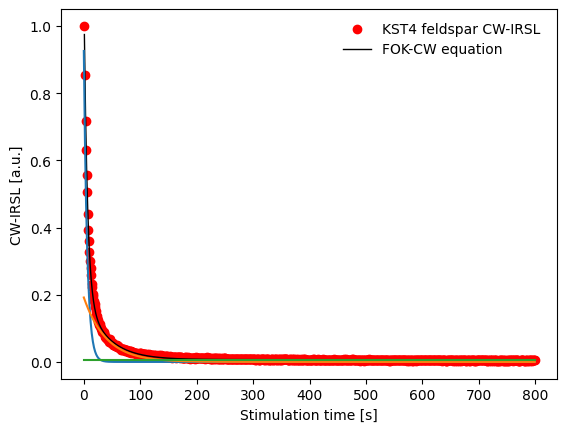

In [3]:
#  deconvolution with FOK-CW equation KST4 feldspar CW-IRSL Data 
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
import requests

# read data file from GitHub
url='https://github.com/vpagonis/EURADOS-2023/raw/main/KST4ph300IR.TXT'

response = requests.get(url)
a = response.text
b = np.array(list(map(float,a.strip("[]").split())))
data = b.reshape(-1,2)

# select the first 800 points in file
x_data,y_data=data[:,0][1:800], data[:,1][1:800]

# normalize the data

y_data = y_data/max(y_data)

# define FOK-CW equation (exponential)
def FOKCW(t, A,tau):
    CW = A*np.exp(-t/tau)   
    return CW

# define function to add the components and background
def total_CW(t, *inis): 
    u = np.array([0 for i in range(len(x_data))])
    As, taus =    inis[0:nPks], inis[nPks:2*nPks]
    bgd = inis[-1]
    for i in range(nPks):        
        u = u+FOKCW(t,As[i],taus[i])
    u = u+bgd 
    return u

# P is the maximum time in CW signal
P=int(max(x_data)) 
t = np.linspace(0, P, P)

# nPks is the number of components
nPks=2

# initial values of A1, tau1, A2, tau2, bgd
inis=[.5,10,.5,50,.01]

# find and plot the best fit to data
params, cov = optimize.curve_fit(total_CW,\
x_data,y_data,p0=inis,maxfev=10000)   

plt.scatter(x_data, y_data,c='r',label='KST4 feldspar CW-IRSL ')
plt.plot(x_data, total_CW(x_data, 
 *params),c='black',label='FOK-CW equation',linewidth=1)

# plot each component 
for i in range(0,nPks): 
    CWi=FOKCW(t, params[i],params[nPks+i])
    plt.plot(t,CWi)
plt.plot(t,[params[-1]]*len(t))
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)  
plt.ylabel('CW-IRSL [a.u.]')
plt.xlabel(r'Stimulation time [s]')

# find residuals and FOM
res=total_CW(x_data, *params)-y_data
FOM=100*np.sum(abs(res))/np.sum(y_data)
print('FOM=',round(FOM,1),' %')

# evaluate errors in parameters for Table
As=[round(x,3) for x in params[0:nPks]]
taus=[round(x,1) for x in params[nPks:2*nPks]] 
dAs=[round(np.sqrt(cov[x][x]),3) for x in range(0,nPks)]
dtaus=[round(np.sqrt(cov[x][x]),2) for x in\
range(nPks,2*nPks)]
bgd=round(params[-1],3) 

# print Table with best fit parameters and errors
myTable = PrettyTable([ "A (a.u.)","dA",\
'tau (s)','dtau (s)','bgd']) 
myTable.add_row([As[0],dAs[0],taus[0],dtaus[0],bgd])
myTable.add_row([As[1],dAs[1],taus[1],dtaus[1],' '])
print(myTable)
plt.show()